In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.linalg
import numba
import scipy.stats
import geostatspy.GSLIB as GSLIB
import geostatspy.geostats as geostats
from scipy.interpolate import interp2d
import scipy.spatial as sp

In [179]:
df_sol = pd.read_csv("solution.csv")
df_prodHist = pd.read_csv("production_history.csv")
df_preProc = pd.read_csv("wellbore_data_preproduction_well.csv")
df_producer = pd.read_csv("wellbore_data_producer_wells.csv")
df_complete = pd.read_csv("wellbore_data_producer_wells_cleaned_complete.csv")


AI = np.load("2d_ai.npy")
sandFraction = np.load("2d_sand_propotion.npy")
shalySandFraction = np.load("2d_shaly_sand_propotion.npy")
shaleFraction = np.load("2d_shale_propotion.npy")
sandyShaleFraction = np.load("2d_sandy_shale_propotion.npy")
topDepth = np.load("2d_top_depth.npy")
resFraction = sandFraction + sandyShaleFraction
nonresFraction = shalySandFraction + shaleFraction
region = np.empty((200,200)); region
region[:] = 2
region[sandFraction < 0.05] = 1
region[resFraction > 0.43] = 3


xgrid = np.arange(0,10,0.05); ygrid = np.arange(0,10,0.05);
xf = np.linspace(1.750,10,16); zf = np.linspace(-3040,-3070,16)
x2d, y2d = np.meshgrid(xgrid,ygrid);
x2df, z2df = np.meshgrid(xf,zf); y2df = 11.75 - x2df;
woc2d = np.full((200, 200), -3067.4)

gridarray = np.transpose(np.stack((AI.flatten(),resFraction.flatten(),topDepth.flatten(),x2d.flatten(),y2d.flatten(),region.flatten())));
df_grid = pd.DataFrame(gridarray, columns = ['AI','Reservoir Fraction','Depth','X','Y','Region'])
# pd.plotting.scatter_matrix(df_grid)

well_x_index = ((df_complete['X, m'].values-25)/50).astype('int')
well_y_index = ((df_complete['Y, m'].values-25)/50).astype('int')
df_complete['AI from Map'] = AI[well_x_index,well_y_index]
df_complete['resFraction from Map'] = resFraction[well_x_index,well_y_index]
df_complete['Region'] = region[well_x_index,well_y_index]
df_complete['Top Depth'] = topDepth[well_y_index,well_x_index]
df_complete['WOR'] = df_complete['Cum_wat_prod_3_yr']/df_complete['Cum_oil_prod_3_yr']
df_complete['Total Prod'] = df_complete['Cum_oil_prod_3_yr']+df_complete['Cum_wat_prod_3_yr']


for i in range(1,84):
    df_complete.loc[df_complete['Well_ID'] == 'Well_no_{}'.format(i), 'Well Top'] = df_complete[df_complete['Well_ID'] == "Well_no_{}".format(i)]['Depth, m'].min()
    df_complete.loc[df_complete['Well_ID'] == 'Well_no_{}'.format(i), 'Well Bottom'] = df_complete[df_complete['Well_ID'] == "Well_no_{}".format(i)]['Depth, m'].max()
    df_complete.loc[df_complete['Well_ID'] == 'Well_no_{}'.format(i), 'AI averaged'] = df_complete[df_complete['Well_ID'] == "Well_no_{}".format(i)]['Acoustic Impedance, kg*s/m^2'].median()

In [3]:
def nanperlayer(df = df_complete):
    countnan = np.zeros((20,10))
    
    for i in range(0,20):
        dfi = df[df['Layer'] == i+1]
        countnan[i,0] = dfi['Porosity, fraction'].isna().sum()
        countnan[i,1] = dfi['Permeability, mD'].isna().sum()
        countnan[i,2] = dfi['Acoustic Impedance, kg*s/m^2'].isna().sum()
        countnan[i,3] = dfi['Rock facies'].isna().sum()
        countnan[i,4] = dfi['Density, g/cm3'].isna().sum()
        countnan[i,5] = dfi['Compressible velocity, m/s'].isna().sum()
        countnan[i,6] = dfi['Youngs modulus, GPa'].isna().sum()
        countnan[i,7] = dfi['Shear velocity, m/s'].isna().sum()
        countnan[i,8] = dfi['Shear modulus, GPa'].isna().sum()
        countnan[i,9] = dfi['Facies code'].isna().sum()
    return countnan

In [39]:
def varioformat(variolayer):
    del variolayer['hmin1']
    del variolayer['hmin2']
    del variolayer['dip1']
    del variolayer['dip2']
    variolayer['hmaj1'] = variolayer.pop('hmax1')
    variolayer['hmaj2'] = variolayer.pop('hmax2')
    variolayer['hmin1'] = variolayer.pop('hmed1')
    variolayer['hmin2'] = variolayer.pop('hmed2')

    
    return variolayer

In [41]:
def faciescode(df = df_complete):
    
    faciesDict = {'Sandstone': 0, 'Shaly sandstone': 0, 'Sandy shale': 1, 'Shale': 1, np.nan: np.nan}
    df['Facies code'] = [faciesDict[x] for x in df['Rock facies'].values]
    
    return df

In [200]:
def krigfacies(df):
    fig = plt.figure(figsize = [15,15])
    ikall = np.zeros([200,200,20])
    for i in range(1,21):
        ikout = krigfacieslayer(df,i)
        ikall[:,:,i-1] = np.flip(ikout[:,:,0],0)

        plt.subplot(7,3,i)
        plt.imshow(ikall[:,:,i-1])
        plt.colorbar()
        #plt.gca().invert_yaxis()
        plt.title('Layer {}'.format(i))

        df = impute(df,ikall,'Facies code')
    
    return df

In [201]:
# Indicator kriging on rock facies (2d)



def krigfacieslayer(df = df_complete,layer = 1):

    df_layer_target_values, df_layer_given_values = df_split(df, 'Facies code', layer)

    trendlayer = np.ones([1,1])
    gcdflayer = [(df_layer_given_values['Facies code'].count()-df_layer_given_values['Facies code'].sum())/df_layer_given_values['Facies code'].count(),df_layer_given_values['Facies code'].sum()/df_layer_given_values['Facies code'].count()]
    #gcdflayer = gcdf/df_layer_given_values['Facies code'].count()
    variolayer = []                                # the variogram list
    variolayer.append(geostats.make_variogram_3D(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,dip1=0,hmax1=500,hmed1=500,hmin1=0)) # shale indicator variogram
    variolayer.append(geostats.make_variogram_3D(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,dip1=0,hmax1=500,hmed1=500,hmin1=0)) # sand indicator variogram

    variolayer[0] = varioformat(variolayer[0])
    variolayer[1] = varioformat(variolayer[1])

    ikout = geostats.ik2d(df_layer_given_values,'X, m','Y, m','Facies code',ivtype=0,koption=0,ncut=2,
                          thresh=[0,1],gcdf=gcdflayer,trend=trendlayer,tmin=-10000,tmax=10000,nx=200,xmn=0,xsiz=50,
                          ny=200,ymn=0,ysiz=50,ndmin=0,ndmax=10,radius=1000,ktype=0,vario=variolayer)
    
    return ikout

In [165]:
def impute(df,ikall,prop):
    
    for layer in range(1,21):
        df_layer_target_values, df_layer_given_values = df_split(df, prop, layer)
        for i in range(0,len(df_layer_target_values)):
            xcoor = int((df_layer_target_values['X, m'].values[i]-25)/50)
            ycoor = int((df_layer_target_values['Y, m'].values[i]-25)/50)
            value = ikall[ycoor,xcoor,layer-1]
            if prop == 'Facies code':
                value = round(value)
                
            df.loc[((df['Layer'] == layer) & (df['X, m'] == xcoor*50+25)) & (df['Y, m'] == ycoor*50+25),prop] = value
            
    return df
    
    
            
        

Data for IK3D: Variable column Facies code
  Number   = 73
Setting up rotation matrices for variogram and search
Working on the kriging
   currently on estimate 0
   currently on estimate 4000
   currently on estimate 8000
   currently on estimate 12000
   currently on estimate 16000
   currently on estimate 20000
   currently on estimate 24000
   currently on estimate 28000
   currently on estimate 32000
   currently on estimate 36000
Data for IK3D: Variable column Facies code
  Number   = 83
Setting up rotation matrices for variogram and search
Working on the kriging
   currently on estimate 0
   currently on estimate 4000
   currently on estimate 8000
   currently on estimate 12000
   currently on estimate 16000
   currently on estimate 20000
   currently on estimate 24000
   currently on estimate 28000
   currently on estimate 32000
   currently on estimate 36000
Data for IK3D: Variable column Facies code
  Number   = 83
Setting up rotation matrices for variogram and search
Working

   currently on estimate 20000
   currently on estimate 24000
   currently on estimate 28000
   currently on estimate 32000
   currently on estimate 36000
Data for IK3D: Variable column Facies code
  Number   = 83
Setting up rotation matrices for variogram and search
Working on the kriging
   currently on estimate 0
   currently on estimate 4000
   currently on estimate 8000
   currently on estimate 12000
   currently on estimate 16000
   currently on estimate 20000
   currently on estimate 24000
   currently on estimate 28000
   currently on estimate 32000
   currently on estimate 36000
 x,y,z offsets = 0.0,200.0
  Estimated   40000 blocks 
      average   0.14587004853524396  variance  9.789449874182676e-05
  Estimated   40000 blocks 
      average   0.1422598395509405  variance  0.00015126453574178939
  Estimated   40000 blocks 
      average   0.14265061335008114  variance  0.00018229429221476579
  Estimated   40000 blocks 
      average   0.14358131161053891  variance  0.000101592

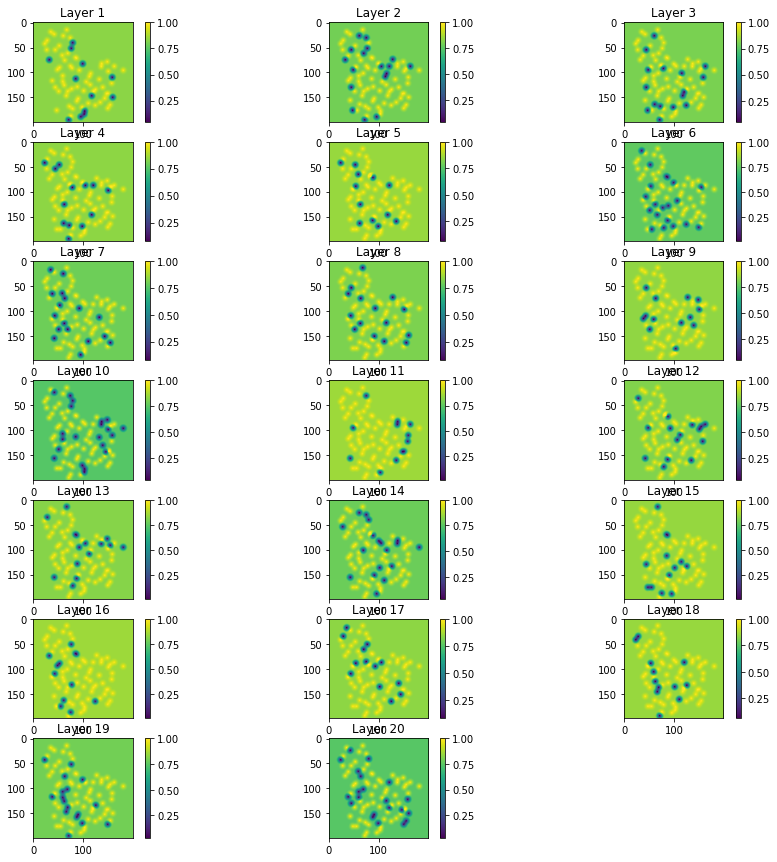

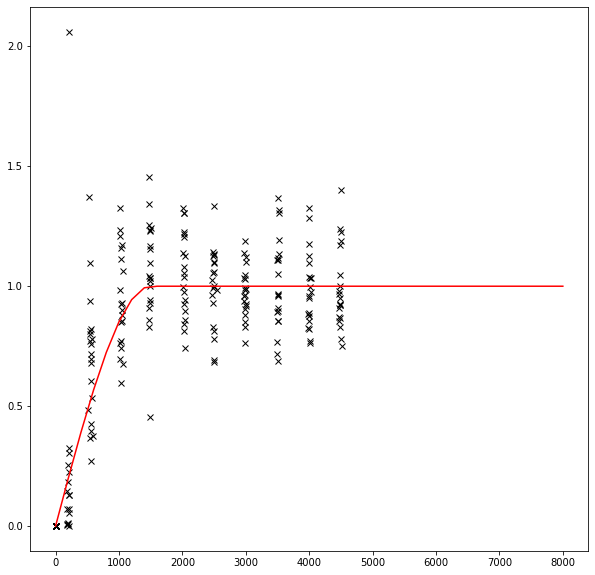

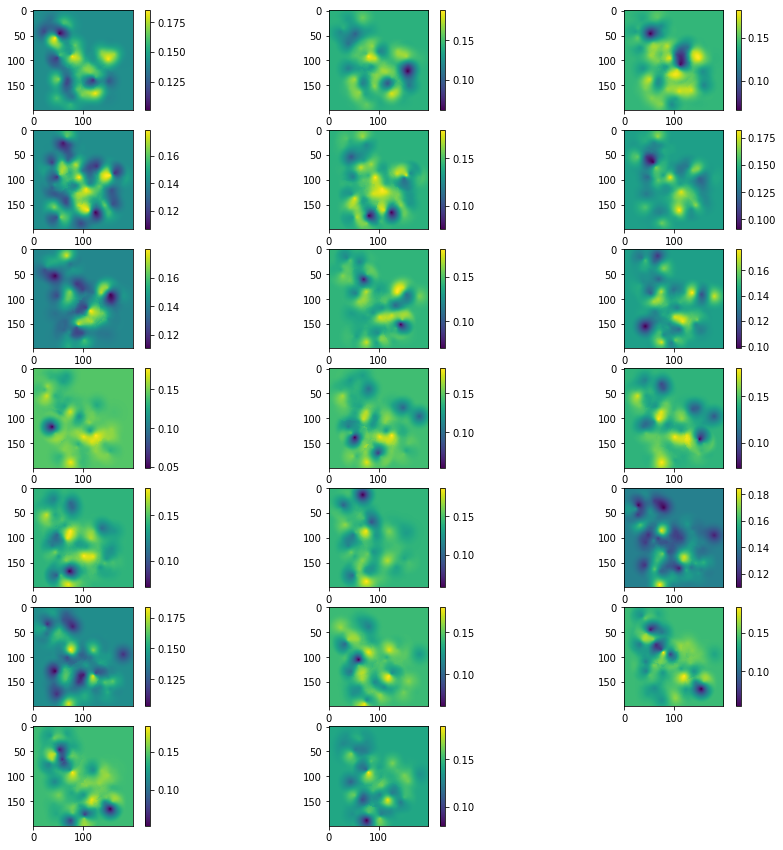

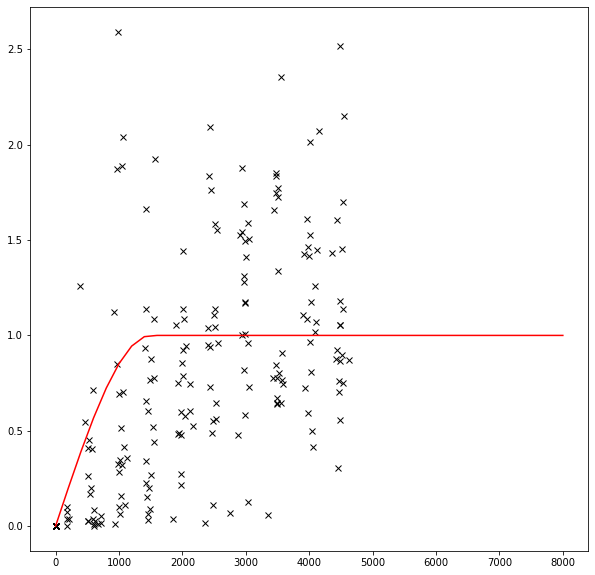

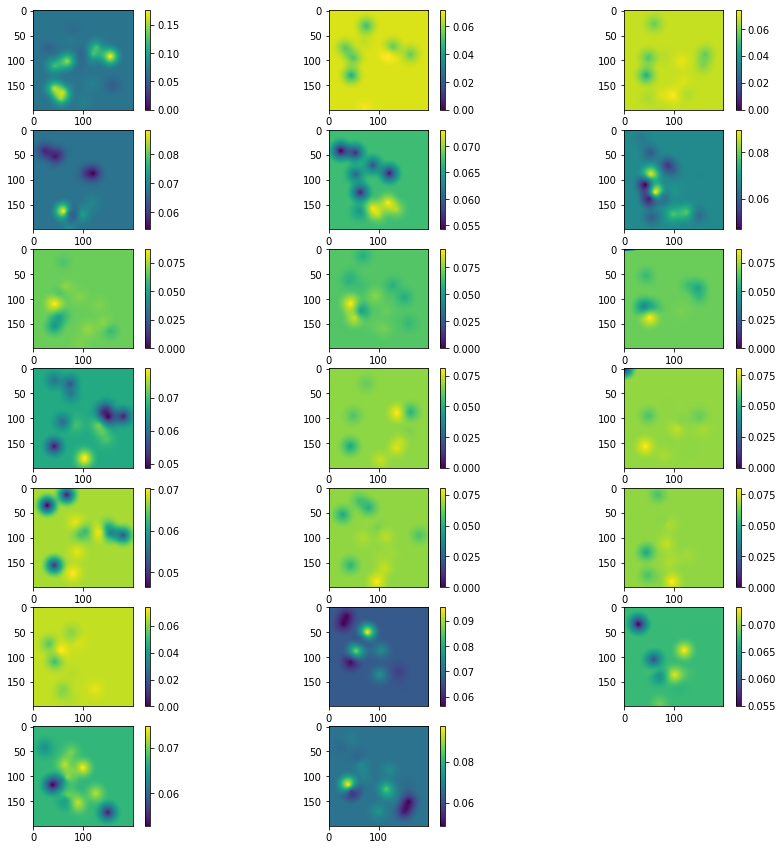

In [251]:
df_complete = pd.read_csv("wellbore_data_producer_wells_cleaned_complete.csv")
df_complete = faciescode(df_complete)
prop = 'Porosity, fraction'


df_complete = krigfacies(df_complete)
df_complete = krigprop(df_complete,prop,0)
df_complete = krigprop(df_complete,prop,1)

In [9]:
def df_split(df = df_complete, prop = 'Porosity, fraction',layer = 1):
    # Pull x, y, and value from subset for a specific layer. Split into df with and without nan.
    df_layer = df[df['Layer'] == layer][['X, m','Y, m',prop]]
    df_layer_target_values = df_layer[df_layer[prop].isna()]
    df_layer_given_values = df_layer.dropna()
    
    return (df_layer_target_values, df_layer_given_values)

In [12]:
def df_distribution_check(df = df_layer_given_values, prop = 'Porosity, fraction'):
    
    df['Normal'], _, _ = geostats.nscore(df,prop)
    
    plt.subplot(131)
    plt.hist(df[prop])
    #plt.xlim([0.05,0.25]); plt.ylim([0,1.0])
    plt.xlabel(prop)
    plt.ylabel('Frequency');
    plt.grid(True)

    plt.subplot(132)  
    plt.hist(df['Normal'])
    #plt.xlim([-3.0,3.0]); plt.ylim([0,1.0])
    plt.xlabel('Normalized')
    plt.ylabel('Frequency')
    plt.grid(True)
    
    plt.subplot(133)
    sns.scatterplot(data = df, x="X, m", y="Y, m", hue = 'Normal')
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
    plt.show()    

In [216]:
def variogramplots(df,prop,facies):
    azimuth = 0
    tmin = -10000
    tmax = 10000
    xlag = 500
    xltol = 250
    nlag = 10
    atol = 90
    bandwh = 10000
    isill = 1
    
    df['Normal'], _, _ = geostats.nscore(df,prop)
    
    lag = np.zeros((20,nlag+2)); gamma = np.zeros((20,nlag+2)); npp = np.zeros((20,nlag+2));
    fig = plt.figure(figsize = [10,10])
    for i in range(0,20):
        df_layer_target_values, df_layer_given_values = df_split(df[df['Facies code']==facies], 'Normal', i+1)
        lag[i,:], gamma[i,:], npp[i,:] = geostats.gamv(df_layer_given_values,'X, m','Y, m','Normal',tmin,tmax,xlag,xltol,nlag,azimuth,atol,bandwh,isill)
        plt.plot(lag[i,:],gamma[i,:],'x',color = 'black',label = 'Layer' +str(i+1))

In [250]:
def krigprop(df_complete,prop,facies):

    variogramplots(df_complete,prop,facies)

    kmap = np.zeros([200,200,20]); vmap = np.zeros([200,200,20])

    #plt.plot(lag[i,:],gamma[i,:],'x',color = 'black',label = 'Azimuth' +str(azimuth[i]))
    #        plt.plot([0,2000],[1.0,1.0],color = 'black')
    #        plt.xlabel('Lag Distance (m)')
    #        plt.ylabel('Gamma')
    #        plt.xlim([0,nlag*xlag])
    #        plt.ylim([0,1.8])
    #        plt.legend(loc='upper left')
    #        plt.grid(True)




    nug = 0; nst = 1                                             # 2 nest structure variogram model parameters
    it1 = 1; cc1 = 1; azi1 = 0; dip1 = 0; hmax1 = 1500; hmed1 = 1500; hmin1 = 0
    it1 = 1; cc2 = 0; azi2 = 0; dip2 = 0; hmax2 = 0; hmed2 = 0; hmin2 = 0
    vario = geostats.make_variogram_3D(nug,nst,it1,cc1,azi1,dip1,hmax1,hmed1,hmin1)
    vario = varioformat(vario)
    nlag = 40; xlag = 200;
    index_maj,h_maj,gam_maj,cov_maj,ro_maj = geostats.vmodel(nlag,xlag,azi1,vario)

    plt.plot(h_maj,gam_maj,color ='red')
    fig = plt.figure(figsize = [15,15])

    for i in range(0,20):
        layer = i+1
        df_layer_target_values, df_layer_given_values = df_split(df_complete[df_complete['Facies code']==facies], prop, layer)

        skmean = np.nanmean(df_complete[df_complete['Facies code']==facies][prop].values)
        kmap[:,:,i],vmap[:,:,i] = geostats.kb2d(df_layer_given_values,'X, m','Y, m',prop,tmin=-10000,tmax=10000,nx=200,xmn=0,xsiz=50,
                                  ny=200,ymn=0,ysiz=50,nxdis=1,nydis=1,ndmin=0,ndmax=10,radius=2500,ktype=0,skmean=skmean,vario=vario)

        kmap = np.flip(kmap,0)
        vmap = np.flip(vmap,0)

        plt.subplot(7,3,i+1)
        plt.imshow(kmap[:,:,i])
        plt.colorbar()

    a = impute(df_complete[df_complete['Facies code']==facies],kmap,prop)
    df_complete[df_complete['Facies code']==facies] = a;
    
    return df_complete

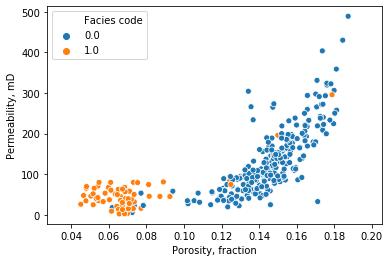

In [252]:
sns.scatterplot(data = df_complete,x = 'Porosity, fraction', y = 'Permeability, mD', hue = 'Facies code')